## Supervised learning on mice phenotype data

Predicting diet from differential expression data was easy with SVMs. It was very neat and regular data, no cells were missing, all values were in a similar range, etc. We will now use a different dataset: the phenotype tables from days 3/4.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, recall_score, matthews_corrcoef, classification_report
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

Since the phenotype data has a lot of missing values which we don't want to deal with *too* much, we wrote some code to remove samples with a very large number of missing values, and also some features. Our data still has some missing values, but not so much to compromise our models anymore.

In [2]:
import pandas as pd
phenotype = pd.read_excel('../example_data/aad0189_DataFileS2.xlsx', sheet_name=None, na_values='x', index_col='@format=column')

In [3]:
# The VO2Max table doesn't follow their own column naming conventions, so fix that first
def rename_vo2_cols(colname):
    return colname.replace('CD', 'CD_').replace('HFD', 'HFD_').replace('__', '_')

phenotype['VO2Max'].rename(columns=rename_vo2_cols, inplace=True)

def split_cd_hfd(input_df):
    input_df.index.name = 'strain'  # change that weird @format=column Excel index label to something meaningful
    input_cd = input_df.filter(regex=r'_CD|CD_') # loc[:, (input_df.columns.str.contains('CD_')) | (input_df.columns.str.contains('_CD'))]
    input_hfd = input_df.filter(regex=r'_HFD|HFD_') #loc[:, (input_df.columns.str.contains('HFD_')) | (input_df.columns.str.contains('_HFD'))]

    input_cd.columns = input_cd.columns.str.replace(r'_CD|CD_', '')
    input_hfd.columns = input_hfd.columns.str.replace(r'_HFD|HFD_', '')
    
    input_cd.insert(0, 'diet', 'CD')
    input_hfd.insert(0, 'diet', 'HFD')
    
    kept_columns = input_cd.columns.intersection(input_hfd.columns)
    
    df_both = pd.concat([input_cd, input_hfd], sort=False)[kept_columns]
    df_both.columns.name = 'experiment'  # added only later
    
    return df_both.reset_index().set_index(['strain', 'diet']).sort_index()

In [4]:
pheno = pd.concat([split_cd_hfd(sheet) for sheet_name, sheet in phenotype.items() if sheet_name != "NEW"], axis=1)

# let's remove the main offenders for missing values, both samples and features
pheno = pheno.loc[pheno.T.isna().sum() < 42]  # samples with lots of missing features
pheno = pheno.loc[:, pheno.isna().sum() < 11]  # features with still too many missing values

# a peek at what missing data we are left with:
# sns.clustermap(pheno.isna(), figsize=(10,10))

We will now cut out some features that would make things too easy for our SVM. Bodyweight-associated and food intake features will be banned from our feature list.

In [5]:
banned = ["KNOWN_BATCH_EFFECT_BY_COHORT_ORDER", "BWGain", "Mass", "BodyWeight", "Food", "Sacrifice"]
kept_cols = [x for x in pheno.columns if all(b not in x for b in banned)]

data_raw = pheno.loc[:, kept_cols]  # unlike the expression table, the phenotype table already has samples as rows so no transposing needed

In [6]:
target = data_raw.index.to_frame()['diet'].replace({'CD': 0, 'HFD': 1})

### 2.1: Impute missing values

Since most ML algorithms can't deal with NaN values, we will first impute them with the rather primitive `SimpleImputer` class of `sklearn`. Our only choice is whether to use a constant value, the column mean or the column median for the missing values. We will go with median.

Imputer classes have a `fit`, `transform` and `fit_transform` method. Figure out which one you need to fill those missing values.

Unfortunately, SimpleImputer always returns numpy matrices instead of DataFrames, so you should convert the results back to a DF with the correct row/column indices.

In [7]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
data = pd.DataFrame(imputer.fit_transform(data_raw) , index=data_raw.index, columns=data_raw.columns)

# data now contains no missing values -- they were filled with the column medians
data

experiment     BWLoss_AfterExercise_[%]  DiastolicBP_NIBP_[mmHg]  \
strain   diet                                                      
BXD1     CD                   -1.771397                  89.2000   
         HFD                  13.392706                  78.2000   
BXD100   CD                    1.120000                  68.6700   
         HFD                  10.260767                  59.7625   
BXD101   CD                    9.630268                  80.9000   
...                                 ...                      ...   
BXD99    HFD                  19.584334                  98.4900   
C57BL/6J CD                    2.855957                  93.5000   
         HFD                   5.971373                  77.1250   
DBA/2J   CD                    5.944125                  87.5000   
         HFD                  19.704068                  80.2500   

experiment     SystolicBP_NIBP_[mmHg]  HeartRate_NIBP_[bpm]  \
strain   diet                                                 
BXD1     CD                   115.400               653.750   
         HFD                  104.600               652.200   
BXD100   CD                   104.300               792.800   
         HFD                   99.385               756.500   
BXD101   CD                   103.200               702.200   
...                               ...                   ...   
BXD99    HFD                  117.655               643.890   
C57BL/6J CD                   117.000               716.125   
         HFD                  111.500               697.250   
DBA/2J   CD                   115.000               702.250   
         HFD                  108.000               688.250   

experiment     DayRER_CLAMS_[ratio]  NightRER_CLAMS_[ratio]  \
strain   diet                                                 
BXD1     CD                0.818600                 0.83840   
         HFD               0.752180                 0.75814   
BXD100   CD                0.822000                 0.88300   
         HFD               0.763000                 0.77600   
BXD101   CD                0.776800                 0.80000   
...                             ...                     ...   
BXD99    HFD               0.757000                 0.76800   
C57BL/6J CD                0.882850                 0.93275   
         HFD               0.767250                 0.78330   
DBA/2J   CD                0.817750                 0.88225   
         HFD               0.776925                 0.78555   

experiment     24hRER_CLAMS_[ratio]  DayVO2_CLAMS_[mL/kg/hr]  \
strain   diet                                                  
BXD1     CD                0.834000                  2509.52   
         HFD               0.754800                  2432.00   
BXD100   CD                0.858000                  2545.00   
         HFD               0.771000                  2709.00   
BXD101   CD                0.784000                  2722.00   
...                             ...                      ...   
BXD99    HFD               0.764000                  2544.00   
C57BL/6J CD                0.912800                  2675.00   
         HFD               0.776875                  2936.00   
DBA/2J   CD                0.856450                  3227.00   
         HFD               0.782100                  2565.00   

experiment     NightVO2_CLAMS_[mL/kg/hr]  24hVO2_CLAMS_[mL/kg/hr]  ...  \
strain   diet                                                      ...   
BXD1     CD                    2782.4668                 2722.753  ...   
         HFD                   2743.6000                 2584.000  ...   
BXD100   CD                    2997.0000                 2854.000  ...   
         HFD                   3156.0000                 2983.000  ...   
BXD101   CD                    3333.0000                 3102.000  ...   
...                                  ...                      ...  ...   
BXD99    HFD                   2771.0000          

### 2.2.1: Look at the value ranges of different features. Standardize the data
`data.describe()` can give you an overview of the means, standard deviations, etc. of the different features. If you take a close look at the `mean` or `max` row, you will see that they span 6-7 orders of magnitude, which isn't desirable when using certain machine learning methods, especially linear ones. A PCA would essentially ignore features with small values in favour of features with large values, but SVM's would struggle with them as well.

We should standardize our data so that the scales of different features become comparable. For reasons to be clarified later, we will use the `StandardScaler` class instead of our good old pandas one-liner. It has a similar interface to the previously used `SimpleImputer`: the methods `fit`, `transform` and `fit_transform` are available here as well.

In [8]:
data.describe()

experiment,BWLoss_AfterExercise_[%],DiastolicBP_NIBP_[mmHg],SystolicBP_NIBP_[mmHg],HeartRate_NIBP_[bpm],DayRER_CLAMS_[ratio],NightRER_CLAMS_[ratio],24hRER_CLAMS_[ratio],DayVO2_CLAMS_[mL/kg/hr],NightVO2_CLAMS_[mL/kg/hr],24hVO2_CLAMS_[mL/kg/hr],...,%MONO.Monocyte_[%],%EOS.Eosinophil_[%],%BASO.Basophil_[%],%LUC.LargeUnknownCells_[%],#NEUTR.Neutrophil_[#*10^3/µL],#LYMPH.Lymphocyte_[#*10^3/µL],#MONO.Monocyte_[#*10^3/µL],#EOS.Eosinophil_[#*10^3/µL],#BASO.Basophil_[#*10^3/µL],#LUC.LargeUnknownCells_[#*10^3/µL]
count,89.000000,89.00000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,...,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000
mean,6.204878,79.37041,108.190054,682.886891,0.778249,0.811412,0.797451,2492.766322,2924.517524,2741.590607,...,2.269697,4.171831,0.151997,1.012843,0.962946,5.659346,0.159172,0.290011,0.016225,0.080860
std,6.634703,9.95009,8.107149,41.215783,0.040135,0.056914,0.049297,322.167783,384.337298,357.692671,...,1.011577,4.519580,0.082439,1.145023,0.560520,2.632939,0.093617,0.457211,0.037971,0.099476
min,-6.704486,58.00000,89.400000,584.000000,0.640000,0.654000,0.649000,1716.000000,1935.000000,1832.000000,...,0.800000,0.780000,0.025000,0.100000,0.190000,1.620000,0.030000,0.040000,0.000000,0.000000
25%,1.932949,73.80000,103.200000,657.000000,0.752180,0.773600,0.767000,2312.000000,2653.504000,2502.000000,...,1.500000,2.050000,0.100000,0.370000,0.592000,3.880000,0.090000,0.140000,0.000000,0.020000
50%,5.500290,78.87500,107.750000,680.959000,0.776800,0.800000,0.784000,2494.000000,2932.500000,2742.000000,...,2.100000,3.050000,0.140000,0.700000,0.810000,5.500000,0.130000,0.200000,0.010000,0.050000
75%,9.630268,84.62500,113.000000,706.250000,0.800275,0.851600,0.834000,2646.000000,3125.000000,2926.768000,...,2.920000,4.650000,0.200000,1.250000,1.190000,6.670000,0.210000,0.275000,0.020000,0.105000
max,25.909315,105.50000,128.800000,792.800000,0.882850,0.932750,0.912800,3643.000000,4250.000000,4027.000000,...,6.400000,30.750000,0.500000,8.900000,3.010000,15.820000,0.480000,3.950000,0.300000,0.690000


In [9]:
# normalize the data
scaler = StandardScaler()
data_std = pd.DataFrame(scaler.fit_transform(data), index=data.index, columns=data.columns)
data_std.describe()

experiment,BWLoss_AfterExercise_[%],DiastolicBP_NIBP_[mmHg],SystolicBP_NIBP_[mmHg],HeartRate_NIBP_[bpm],DayRER_CLAMS_[ratio],NightRER_CLAMS_[ratio],24hRER_CLAMS_[ratio],DayVO2_CLAMS_[mL/kg/hr],NightVO2_CLAMS_[mL/kg/hr],24hVO2_CLAMS_[mL/kg/hr],...,%MONO.Monocyte_[%],%EOS.Eosinophil_[%],%BASO.Basophil_[%],%LUC.LargeUnknownCells_[%],#NEUTR.Neutrophil_[#*10^3/µL],#LYMPH.Lymphocyte_[#*10^3/µL],#MONO.Monocyte_[#*10^3/µL],#EOS.Eosinophil_[#*10^3/µL],#BASO.Basophil_[#*10^3/µL],#LUC.LargeUnknownCells_[#*10^3/µL]
count,8.900000e+01,8.900000e+01,8.900000e+01,8.900000e+01,8.900000e+01,8.900000e+01,8.900000e+01,8.900000e+01,8.900000e+01,8.900000e+01,...,8.900000e+01,8.900000e+01,8.900000e+01,8.900000e+01,8.900000e+01,8.900000e+01,8.900000e+01,8.900000e+01,8.900000e+01,8.900000e+01
mean,-8.482603e-17,-2.780235e-16,-4.748075e-16,2.744683e-15,-2.754819e-15,-2.826703e-15,-8.532501e-16,6.056329e-16,5.239255e-17,-1.216256e-16,...,3.729850e-16,-7.796510e-17,-2.357665e-16,9.979533e-18,3.243348e-17,-1.434558e-16,7.547022e-17,-1.953805e-16,6.798557e-17,-8.233115e-17
std,1.005666e+00,1.005666e+00,1.005666e+00,1.005666e+00,1.005666e+00,1.005666e+00,1.005666e+00,1.005666e+00,1.005666e+00,1.005666e+00,...,1.005666e+00,1.005666e+00,1.005666e+00,1.005666e+00,1.005666e+00,1.005666e+00,1.005666e+00,1.005666e+00,1.005666e+00,1.005666e+00
min,-1.956758e+00,-2.159929e+00,-2.330846e+00,-2.412842e+00,-3.464152e+00,-2.781429e+00,-3.028404e+00,-2.424722e+00,-2.589194e+00,-2.557347e+00,...,-1.461109e+00,-7.547269e-01,-1.549220e+00,-8.017435e-01,-1.386794e+00,-1.542851e+00,-1.387613e+00,-5.499162e-01,-4.297101e-01,-8.174637e-01
25%,-6.475246e-01,-5.630070e-01,-6.190001e-01,-6.316406e-01,-6.532192e-01,-6.681216e-01,-6.211959e-01,-5.642728e-01,-7.091402e-01,-6.736176e-01,...,-7.651992e-01,-4.721353e-01,-6.343018e-01,-5.646043e-01,-6.655385e-01,-6.796314e-01,-7.430708e-01,-3.299596e-01,-4.297101e-01,-6.152702e-01
50%,-1.067992e-01,-5.007158e-02,-5.458722e-02,-4.704058e-02,-3.630733e-02,-2.016391e-01,-2.743947e-01,3.850997e-03,2.088713e-02,1.151024e-03,...,-1.687051e-01,-2.496222e-01,-1.463457e-01,-2.747676e-01,-2.744100e-01,-6.086327e-02,-3.133759e-01,-1.979857e-01,-1.648611e-01,-3.119800e-01
75%,5.192090e-01,5.310868e-01,5.966584e-01,5.700602e-01,5.519138e-01,7.101221e-01,7.456088e-01,4.783280e-01,5.245870e-01,5.206329e-01,...,6.465036e-01,1.063988e-01,5.855885e-01,2.082936e-01,4.073736e-01,3.860248e-01,5.460139e-01,-3.301828e-02,9.998795e-02,2.440521e-01
max,2.986732e+00,2.640944e+00,2.556598e+00,2.681882e+00,2.621024e+00,2.144026e+00,2.353134e+00,3.590522e+00,3.468288e+00,3.613975e+00,...,4.106170e+00,5.913990e+00,4.245259e+00,6.927236e+00,3.672758e+00,3.880919e+00,3.446454e+00,8.050385e+00,7.515761e+00,6.158212e+00


### 2.2.2: Create a PCA plot from the standardized and non-standardized data

We have provided the outline of the code. Do you agree that feature standardization had a beneficial effect on the PCA transformation?

- not really in origin data, because the distribution didn't seperate even we doing PCA, and feature is hard to cluster.
- However, when we normalize the data, the principle component look good.

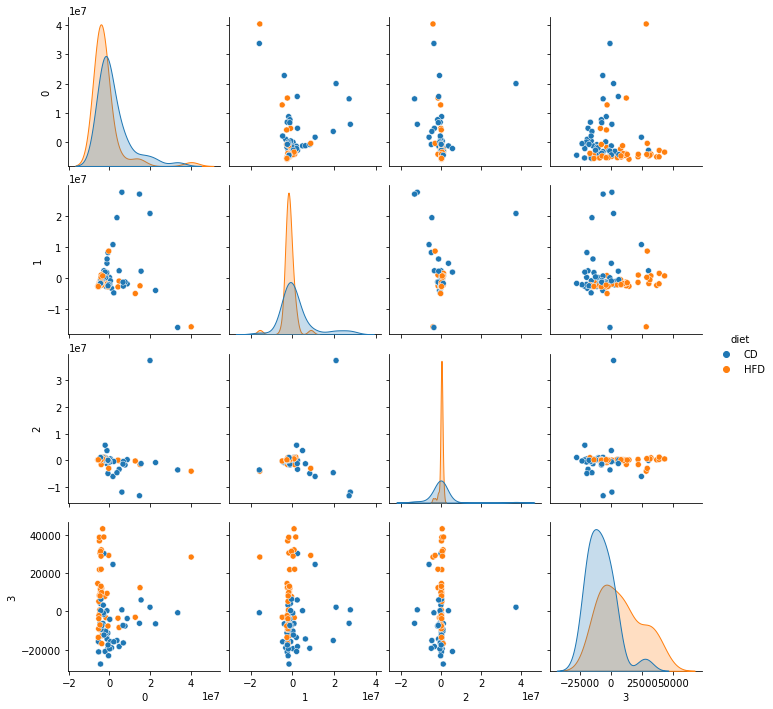

In [10]:
# fit PCA model
pca = PCA(4)
pca_df_non = pd.DataFrame(pca.fit_transform(data), index=data.index)
pca_df_std = pd.DataFrame(pca.fit_transform(data_std), index=data_std.index)

# non-standardized: data
sns.pairplot(pca_df_non.reset_index(), hue='diet')

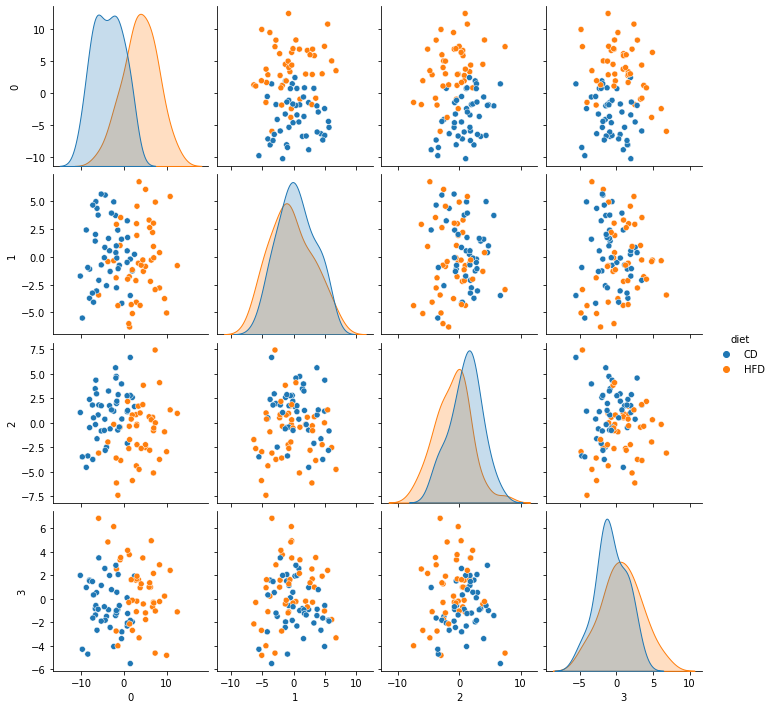

In [11]:
# standardized: data_std
sns.pairplot(pca_df_std.reset_index(), hue='diet')

### 2.3.1: Use an SVC to predict diet from non-standardized phenotype data
Try the `rbf` kernel for a change, and use 3-fold stratified cross-validation to calculate the accuracy. Don't bother with looping over the different training/testing splits manually, use the convencience function `cross_val_score`. It shouldn't take more than 3 short lines of code, or 1 longish line.

Make sure to use the non-standardized `data` DataFrame. Watch out, don't try to run a linear SVM, because it will take a long time to reach convergence and you might have to kill your notebook. Use `kernel='rbf'`.

In [12]:
np.mean(cross_val_score(SVC(kernel='rbf'), data, target, cv=3))

0.7195402298850574

### 2.3.2: Try the same on the standardized `data_std` DataFrame.
How does the RBF SVM perform on the standardized data?

In [13]:
np.mean(cross_val_score(SVC(kernel='rbf'), data_std, target, cv=3))

0.9777777777777779

### 2.3.3: Try a linear kernel SVM on the standardized `data_std`
    
Again, just a simple `cross_val_score`. Scikit-learn makes it very easy to test different models with tiny modifications to your code.

In [14]:
np.mean(cross_val_score(SVC(kernel='linear'), data_std, target, cv=3))

0.9659003831417624

### 2.4: Standardize the data fold-by-fold

When we standardized the entire dataset in one go, we cheated a bit. We did not keep the training and testing data fully independent. For a truly honest evaluation, we should derive the standardization parameters (column mean & standard deviation) from the training data only, and apply the same transformation to the test data before prediction. The test data should NOT influence how the training data gets standardized.

You will (temporarily) have to give up on the convenience functions, as you have an extra standardization step to do before fitting and predicting in each fold. Use `StandardScaler`'s `fit_transform` on the training data, and `transform` on the testing data.

Did it influence the accuracy?

- Yes, the accuracy decrease a little.

In [15]:
svc = SVC(kernel='rbf', gamma='auto')
scaler = StandardScaler()
cv = StratifiedKFold(n_splits=3)

fold_accuracies = []
for train_idx, test_idx in cv.split(data, target):
    
    raw_train = data.iloc[train_idx]
    raw_test = data.iloc[test_idx]
    
    target_train = target.iloc[train_idx]
    target_test = target.iloc[test_idx]
    
    std_train = scaler.fit_transform(raw_train)
    std_test = scaler.transform(raw_test)
    
    svc.fit(std_train, target_train)
    acc = svc.score(std_test, target_test)
    
    fold_accuracies.append(acc)

np.mean(fold_accuracies)

0.9659003831417624

### 2.4.2: Standardize inside the convenience functions
`sklearn` helps us string together steps by combining them into `Pipeline` objects. We can combine a standardization and a prediction method into a single, indivisible unit, and `sklearn` will make sure that they never violate the principle of keeping the training and testing stages separate, and always uses the appropriate interfaces at every stage.

Those with a keen eye may realize that we cheated the same way when we imputed missing data. You can therefore add the imputation step to the pipeline as well (not that it would change much given how few values had to be imputed).

Once you have created the pipeline, you can pass it to the convenience function `cross_val_score` just like you passed standalone SVC models before.

In [16]:
scaler = StandardScaler()
svc = SVC(kernel='rbf', gamma='auto')

scale_and_svc = Pipeline([('scaler', scaler), ('svc', svc)])
np.mean(cross_val_score(scale_and_svc, data, target, cv=3))

0.9659003831417624

### 2.5: Take a closer look at the most important features

In the previous notebook we extracted feature weights from linear SVMs by accessing a fitted SVM's `.coef_` attribute. We should do the same now, and take a look at the features that the linear SVM assigned the largest weights to.

Train a `linear` SVM with the entire standardized dataset and extract the features with the 5 highest absolute coefficients. Visualize their values using a `pairplot` and color the samples with their diet.

What phenotypic traits came out on top? Can you think of an explanation why they would be affected by diet?

- Red cell distribution and WAT, having different diet then getting different nutrient, so it is easy to say scWAT is changing, and it seem somehow change iron deficiency so effect on red cell distribution

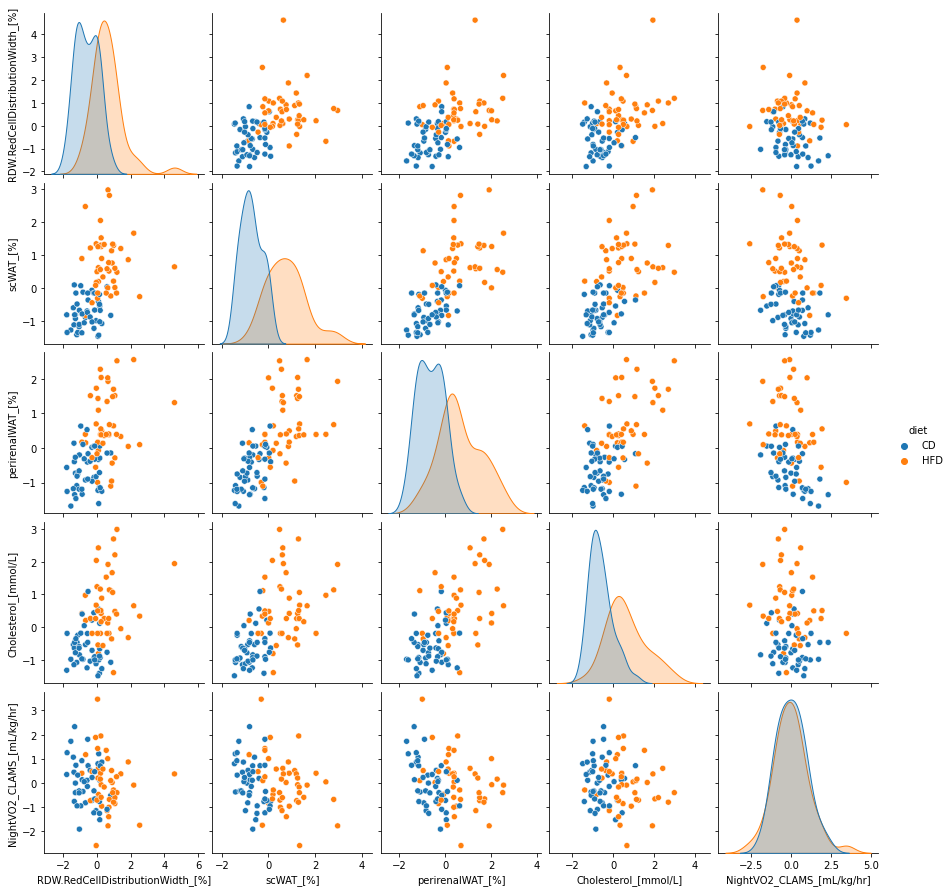

In [17]:
svc = SVC(kernel='linear')
svc.fit(data_std, target)

feature_weights = pd.Series(svc.coef_[0], index=data_std.columns)
top5 = pd.DataFrame(feature_weights.sort_values(ascending=False).iloc[:5])

sns.pairplot(data_std.loc[:, top5.index].reset_index('diet'), hue='diet')

### 2.6: Exclude some more features

For the upcoming tasks, we want an imperfect model for demonstration purposes. So we'll cut out some of the best features to reduce the accuracy of the model. Please keep using `data2` or `data2_std` from now on. You can also experiment with removing even more features.

Quickly check how well an SVM performs on this data.

In [18]:
banned = ["KNOWN_BATCH_EFFECT_BY_COHORT_ORDER", "BWGain", "Mass", "BodyWeight", "Food", "Sacrifice", "RER"]

kept_cols = [x for x in pheno.columns if all(b not in x for b in banned)]

data2 = data.loc[:, kept_cols]
data2_std = pd.DataFrame(StandardScaler().fit_transform(data2), index=data2.index, columns=data2.columns)

np.mean(cross_val_score(scale_and_svc, data2_std, target, cv=3))

0.9206896551724139

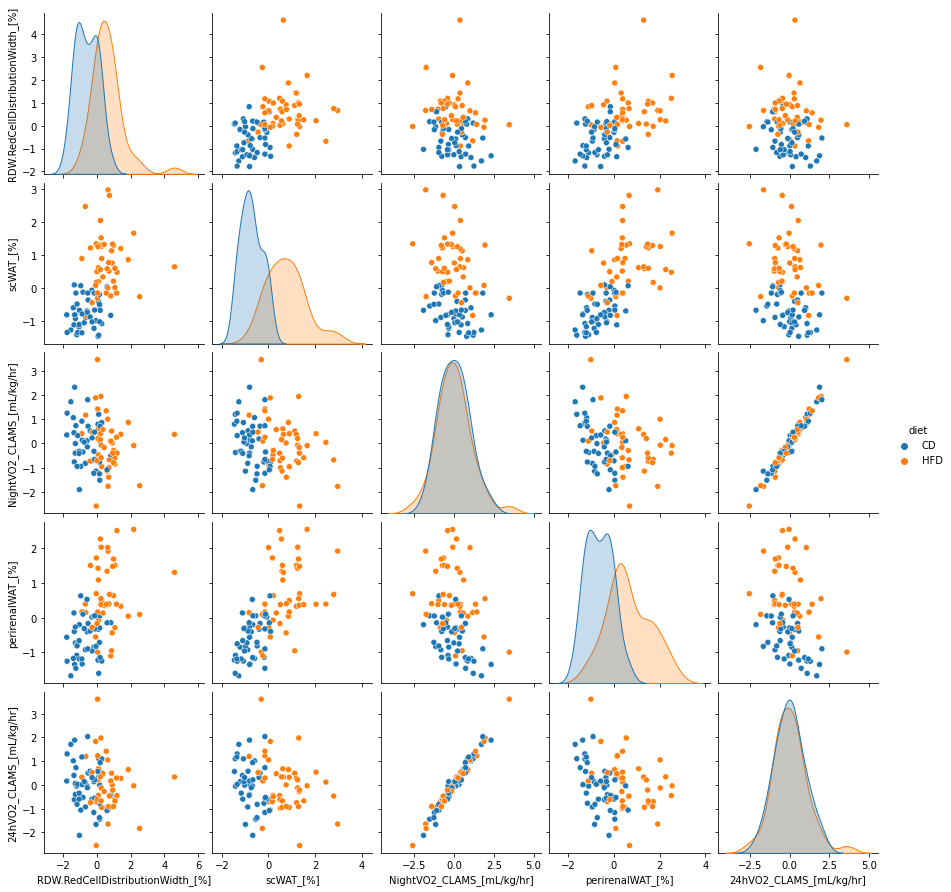

In [19]:
# exclude feature and plot pca again, see whether it is something different
svc = SVC(kernel='linear')
svc.fit(data2_std, target)

feature_weights = pd.Series(svc.coef_[0], index=data2_std.columns)
top5 = pd.DataFrame(feature_weights.sort_values(ascending=False).iloc[:5])

sns.pairplot(data_std.loc[:, top5.index].reset_index('diet'), hue='diet')

### 2.7: Sensitivity, specificity, precision...

In some cases, the accuracy of a prediction is secondary to other quality metrics, such as sensitivity or specificity. For example, HIV sceening tests are optimized for sensitivity at the expense of accuracy, ensuring that almost no HIV-positive individuals test negative. This results in an HIV-scare for a lot of HIV-negative individuals each year (as higher sensitivity always implies a higher false positive rate) but in exchange no case of HIV goes undetected on a screening.

We can tune most ML models similarly, and sacrifice accuracy for higher sensitivity or specificity. But first, simply report the sensitivity of your SVM for detecting a high-fat diet (label `1`). You will find tools in `sklearn` that help you calculate this value. Hint: "recall" is a synonym for sensitivity. All the other synonyms and definitions can be found here https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context)

Make use of the convenience function `cross_val_predict`! It's similar to `cross_val_score`, but instead of returning the accuracies of individual folds, it takes the predicted labels in each fold, and merges + sorts them to match the original order of your samples. This way it guarantees that every prediction comes from a proper cross-validation fold, and the predictions are directly comparable to the target labels.

Sidenote: Feel free to continue with the globally standardized `data2_std` for if you are uncomfortable with the `Pipeline` object.

In [20]:
recall_score(cross_val_predict(scale_and_svc, data2, target, cv=3), target, pos_label=0)

0.9318181818181818

### 2.7.2: Make your SVM 95+% sensitive for HFD
You can adjust the SVM's parameters to increase your sensitivity for mice on an HFD diet. The `class_weight` keyword of `SVC` takes a dictionary with label-weight pairs (ideally with weights summing to 1).

How did it affect the overall accuracy, and the false positive rate (i.e. sensitivity for the other, CD condition)? You can create an overview with `classification_report`.

In [22]:
# recall is sensitive, and make hfd weight larger will truely effect the sensitive for object
hfd_weight = 0.6 # a number between 0 and 1
svc = SVC(kernel='rbf', gamma='auto', class_weight={0:1-hfd_weight, 1:hfd_weight})

scale_and_svc = Pipeline([('imputer', imputer), ('scaler', scaler), ('svc', svc)])
pred = cross_val_predict(scale_and_svc, data2, target, cv=3)
print(classification_report(target, pred))

              precision    recall  f1-score   support

           0       0.95      0.78      0.85        45
           1       0.81      0.95      0.88        44

    accuracy                           0.87        89
   macro avg       0.88      0.87      0.86        89
weighted avg       0.88      0.87      0.86        89



### 2.8: ROC curves
We are often interested the relationship between the model's accuracy and sensitivity, or a more commonly used pair of quality measures: false positive rate vs. sensitivity (aka true positive rate). This is what ROC (receiver operating characteristic) curves display: the trade-off between these two qualities.

In the previous task, you used class weights (used during training) to tune sensitivity. An alternative way is "shifting" the decision boundary before producing the output labels.

Most classification ML methods, despite their categorical output, use continuous internal variables for their predictions, and their final decision is a simple thresholding of this continuous variable. For example, in the case of SVMs, this variable is the data point's signed distance from the separating boundary: positive values are assigned to one class, negative values to the other class. Values close to zero (= close to the boundary) are harder to confidently place in either class, and it's down to the arbitrary threshold how they end up being predicted.

You can create a ROC curve by testing how the choice of threshold affects false positive rate and sensitivity. Needless to say, `sklearn` helps you create such plots. All you need to do is extract the SVM's continuous predictive variables, pass it to the appropriate function with the target labels, and plot the results.

Hint: SVC's can return these continuous internal variables if you call `.decision_function(...)` instead of `.predict(...)`. The convenience function `cross_val_predict` gathers the values returned by the classifier's `predict` function by default, but you can change its behaviour with the `method` keyword.

Optional: you can try to plot several ROC curves on top of each other, each resulting from a different shuffled cross-validation run.

Text(0, 0.5, 'sensitivity')

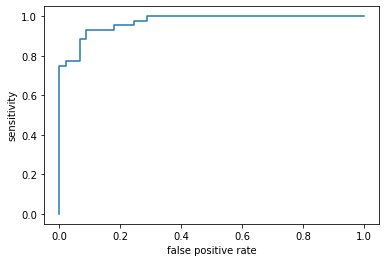

In [23]:
# calculate the probability
pred_decision_vars = cross_val_predict(scale_and_svc, data2, target, cv=3, method='decision_function')

fpr, tpr, thresholds = roc_curve(target, pred_decision_vars)

plt.plot(fpr, tpr)
plt.xlabel('false positive rate')
plt.ylabel('sensitivity')

An alternative internal variable: estimated probability. It has to be turned on manually when initializing the `SVC` with `probability=True`, and it will slow things down a bit. The probability values can be accessed by calling `.predict_proba(...)`. In this case you can call `cross_val_predict(..., method='predict_proba')`.

Watch out, `predict_proba` returns two values, the probabilies for either class, summing to one. You are interested in the second value, which is the probability of your `1` label (HFD).

Text(0, 0.5, 'sensitivity')

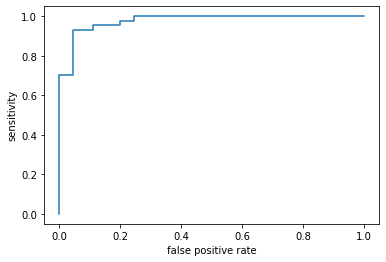

In [24]:
svc_proba = SVC(kernel='rbf', probability=True)
scale_and_svc = Pipeline([('imputer', imputer), ('scaler', scaler), ('svc', svc_proba)])
pred_proba_hfd = cross_val_predict(scale_and_svc, data2, target, cv=3, method='predict_proba')[:,1]

fpr, tpr, thresholds = roc_curve(target, pred_proba_hfd)

plt.plot(fpr, tpr)
plt.xlabel('false positive rate')
plt.ylabel('sensitivity')

### 2.9 Find the threshold for the desired sensitivity / FPR tradeoff
In 2.7.2 you increased sensitivity for HFD (label 1) by telling the SVM to use a higher weight for that class. Since then, you have learned that you could have instead used the SVM's continuous predictive variables, and threshold them to your own liking, instead of leaving it to the SVM's default (0 for `decision_function` and 0.5 for `predict_proba`).

Your task is to find the threshold value (`decision_function` or `predict_proba`, whichever you prefer) that would achieve 95% sensitivity. Remember, the `roc_curve` function returned three vectors: the ROC plot's FPR values, sensitivity values and the threshold that corresponded to them.

Hint: iterate over the sensitivity and threshold values together, and report the first threshold where sensitivity exceeds 0.95. You can iterate over two lists together using Python's `zip` function.

In [25]:
svc_proba = SVC(kernel='rbf', probability=True)
scale_and_svc = Pipeline([('imputer', imputer), ('scaler', scaler), ('svc', svc_proba)])
pred_proba_hfd = cross_val_predict(scale_and_svc, data2, target, cv=3, method='predict_proba')[:,1]

fpr, tpr, thresholds = roc_curve(target, pred_proba_hfd)

for tp, thres in zip(tpr, thresholds):
    if tp > 0.95:
        print(thres)
        break

0.4822177447897749
